In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("avc0706/luna16")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/luna16


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# Check TPU availability and setup
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # This automatically detects TPU
    tf.config.experimental_connect_to_host(tpu.master())  # Connects to the detected TPU
    tf.config.experimental_connect_to_device(tpu)
    tpu_strategy = tf.distribute.TPUStrategy(tpu)  # Use TPUStrategy
    print("TPU initialized successfully.")
except ValueError:
    tpu_strategy = tf.distribute.get_strategy()  # Default strategy if no TPU
    print("TPU not found. Using default strategy.")

# Set matplotlib parameters for better visuals
plt.rcParams['figure.figsize'] = (10, 8)

# Define dataset root path
DATASET_ROOT = "/kaggle/input/luna16"

# Define paths for annotations, candidates, subsets, and segmentation files
ANNOTATIONS_PATH = os.path.join(DATASET_ROOT, "annotations.csv")
CANDIDATES_PATH = os.path.join(DATASET_ROOT, "candidates_V2/candidates_V2.csv")
SEGMENTATION_PATH = os.path.join(DATASET_ROOT, "seg-lungs-LUNA16/seg-lungs-LUNA16")
SUBSETS_PATH = os.path.join(DATASET_ROOT, "subset0/subset0")  # Example subset path

# Helper function to explore nested subset folders
def list_files_in_nested_dir(directory, extension=".mhd"):
    """
    Lists all files with a specific extension in nested subdirectories.
    """
    files = []
    for root, _, filenames in os.walk(directory):
        for filename in filenames:
            if filename.endswith(extension):
                files.append(os.path.join(root, filename))
    return files

# Validate the dataset paths
def validate_dataset_structure():
    print("\n--- Validating Dataset Structure ---")
    
    # Check annotations file
    if os.path.exists(ANNOTATIONS_PATH):
        print(f"Annotations file found: {ANNOTATIONS_PATH}")
    else:
        print(f"Annotations file not found: {ANNOTATIONS_PATH}")
    
    # Check candidates file
    if os.path.exists(CANDIDATES_PATH):
        print(f"Candidates file found: {CANDIDATES_PATH}")
    else:
        print(f"Candidates file not found: {CANDIDATES_PATH}")
    
    # Check segmentation files folder
    if os.path.exists(SEGMENTATION_PATH):
        seg_files = list_files_in_nested_dir(SEGMENTATION_PATH, extension=".mhd")
        if seg_files:
            print(f"Segmentation files found in {SEGMENTATION_PATH}: {seg_files[:5]}")  # Show first 5 files
        else:
            print(f"No .mhd files found in {SEGMENTATION_PATH}.")
    else:
        print(f"Segmentation files directory not found: {SEGMENTATION_PATH}")
    
    # Check subset files
    subset_files = list_files_in_nested_dir(SUBSETS_PATH, extension=".mhd")
    if subset_files:
        print(f"Example .mhd files in {SUBSETS_PATH}: {subset_files[:5]}")  # Show first 5 files
    else:
        print(f"No .mhd files found in {SUBSETS_PATH}. Check nested folder structure.")

# Run dataset validation
validate_dataset_structure()

print("\n--- Initialization Complete ---")
print(f"Dataset Root Path: {DATASET_ROOT}")
print(f"Subset Example Path: {SUBSETS_PATH}")
print(f"Candidates File Path: {CANDIDATES_PATH}")
print(f"Annotations File Path: {ANNOTATIONS_PATH}")
print(f"Segmentation Files Path: {SEGMENTATION_PATH}")


2025-07-24 06:18:30.431731: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753337910.664271      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753337910.738149      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TPU not found. Using default strategy.

--- Validating Dataset Structure ---
Annotations file found: /kaggle/input/luna16/annotations.csv
Candidates file found: /kaggle/input/luna16/candidates_V2/candidates_V2.csv
Segmentation files found in /kaggle/input/luna16/seg-lungs-LUNA16/seg-lungs-LUNA16: ['/kaggle/input/luna16/seg-lungs-LUNA16/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.232058316950007760548968840196.mhd', '/kaggle/input/luna16/seg-lungs-LUNA16/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.247060297988514823071467295949.mhd', '/kaggle/input/luna16/seg-lungs-LUNA16/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604.mhd', '/kaggle/input/luna16/seg-lungs-LUNA16/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.140253591510022414496468423138.mhd', '/kaggle/input/luna16/seg-lungs-LUNA16/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.315214756157389122376518747372.mhd']
Example .mhd files in /kaggle/input/luna16/subset0/subset0: ['/kag

In [3]:
import os
import SimpleITK as sitk
import pandas as pd

# Function to load a single .mhd file and extract voxel array and metadata
def load_ct_scan(mhd_file_path):
    try:
        # Read the .mhd file using SimpleITK
        image = sitk.ReadImage(mhd_file_path)
        
        # Extract the voxel array (CT scan data)
        voxel_array = sitk.GetArrayFromImage(image)
        
        # Extract metadata: spacing, origin, direction
        metadata = {
            "spacing": image.GetSpacing(),
            "origin": image.GetOrigin(),
            "direction": image.GetDirection()
        }
        
        return voxel_array, metadata
    except Exception as e:
        print(f"Error loading CT scan from {mhd_file_path}: {e}")
        return None, None

# Function to load annotations and candidates files
def load_annotations_and_candidates(annotations_path, candidates_path):
    try:
        # Load annotations and candidates using pandas
        annotations_df = pd.read_csv(annotations_path)
        candidates_df = pd.read_csv(candidates_path)
        
        return annotations_df, candidates_df
    except Exception as e:
        print(f"Error loading annotations or candidates: {e}")
        return None, None

# Function to list all .mhd files in a directory and its subdirectories
def list_files_in_nested_dir(directory, extension=".mhd"):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(extension):
                file_paths.append(os.path.join(root, file))
    return file_paths

# Function to map annotations to corresponding CT scans based on 'seriesuid'
def map_annotations_to_scans(annotations_df, scan_files):
    # Extract the 'seriesuid' column from annotations
    annotations_seriesuids = annotations_df['seriesuid'].values
    
    # Find which scan files correspond to each annotation
    scans_with_annotations = []
    for scan_file in scan_files:
        # Extract the seriesuid from the filename (assuming it's the first part of the seriesuid)
        scan_seriesuid = scan_file.split('/')[-1].split('.')[0]  # Get the seriesuid from the filename
        
        # Check if any annotation seriesuid starts with the extracted scan_seriesuid
        if any(annotations_seriesuid.startswith(scan_seriesuid) for annotations_seriesuid in annotations_seriesuids):
            scans_with_annotations.append(scan_file)
    
    return scans_with_annotations

# Define paths
ANNOTATIONS_PATH = '/kaggle/input/luna16/annotations.csv'
CANDIDATES_PATH = '/kaggle/input/luna16/candidates_V2/candidates_V2.csv'
SUBSETS_PATH = '/kaggle/input/luna16/subset0/'

# Load annotations and candidates
annotations_df, candidates_df = load_annotations_and_candidates(ANNOTATIONS_PATH, CANDIDATES_PATH)

# Get list of .mhd files
scan_files = list_files_in_nested_dir(SUBSETS_PATH, extension=".mhd")

# Map annotations to scans
scans_with_annotations = map_annotations_to_scans(annotations_df, scan_files)

# Display results
if annotations_df is not None and candidates_df is not None:
    print("Annotations DataFrame:")
    print(annotations_df.head())

    print("\nCandidates DataFrame:")
    print(candidates_df.head())

print("\nScans with Annotations:")
print(scans_with_annotations[:5])  # Display the first 5 scans


Annotations DataFrame:
                                           seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
3 -391.081276     8.143262  
4 -405.493732    18.545150  

Candidates DataFrame:
                                           seriesuid     coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  68.420000  -74.480000   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -95.209361  -91.809406   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -24.76675

In [4]:
import os
import numpy as np
import SimpleITK as sitk
import scipy.ndimage as ndi
from skimage.transform import resize

# Helper function to load .mhd and .raw files
def load_mhd_raw(file_path):
    img = sitk.ReadImage(file_path)
    img_array = sitk.GetArrayFromImage(img)
    return img_array, img

# Lung Segmentation
def apply_lung_mask(scan_file, mask_file):
    scan, _ = load_mhd_raw(scan_file)
    mask, _ = load_mhd_raw(mask_file)
    
    # Ensure the mask is binary (0 or 1), which is important for segmentation
    mask = (mask > 0).astype(np.uint8)
    
    # Apply the mask to the scan (i.e., set all non-lung voxels to 0)
    segmented_lung = scan * mask
    return segmented_lung

# Intensity Normalization with additional checks
def normalize_intensity(scan):
    # Normalize voxel intensities to [0, 1]
    min_intensity = np.min(scan)
    max_intensity = np.max(scan)
    
    # Avoid division by zero if scan is constant
    if min_intensity == max_intensity:
        normalized_scan = np.zeros_like(scan)  # or np.ones_like(scan) if preferred
    else:
        normalized_scan = (scan - min_intensity) / (max_intensity - min_intensity)
    
    return normalized_scan

# Resampling (Isotropic Voxel Spacing) using SimpleITK
def resample_scan(scan, sitk_img, target_spacing=(1, 1, 1)):
    original_spacing = sitk_img.GetSpacing()
    original_size = sitk_img.GetSize()
    
    # Calculate new size based on target spacing
    new_size = [
        int(np.round(original_size[i] * (original_spacing[i] / target_spacing[i])))
        for i in range(3)
    ]
    
    resampled_img = sitk.Resample(
        sitk_img,
        new_size,
        sitk.Transform(),
        sitk.sitkBSpline,  # Use B-spline interpolation for medical images
        sitk_img.GetOrigin(),
        target_spacing,
        sitk_img.GetDirection(),
        0,
        sitk_img.GetPixelID(),
    )
    
    resampled_scan = sitk.GetArrayFromImage(resampled_img)
    return resampled_scan

# Resize to final shape with anti-aliasing
def resize_scan(scan, target_shape=(128, 128, 128)):
    resized_scan = resize(scan, target_shape, mode='reflect', anti_aliasing=True, preserve_range=True)
    return resized_scan

# Custom 3D Data Augmentation with more transformations
def augment_scan_3d(scan):
    # Random rotation along any axis
    axes = [(1, 2), (0, 2), (0, 1)]
    axis = axes[np.random.randint(0, len(axes))]  # Select a random axis pair
    angle = np.random.uniform(-30, 30)  # Rotation angle in degrees
    rotated_scan = ndi.rotate(scan, angle, axes=axis, reshape=False, mode='nearest')
    
    # Random flipping along any axis
    flip_axis = np.random.randint(0, 3)  # Choose an axis to flip
    flipped_scan = np.flip(rotated_scan, axis=flip_axis) if np.random.random() > 0.5 else rotated_scan
    
    # Add random Gaussian noise
    noise = np.random.normal(0, 0.01, flipped_scan.shape)
    noisy_scan = flipped_scan + noise
    
    # Optional: Random zoom (scaling)
    zoom_factor = np.random.uniform(0.9, 1.1)
    zoomed_scan = ndi.zoom(noisy_scan, zoom_factor, order=1)  # Bilinear interpolation
    
    # Optional: Random shifting (translation)
    shift_x = np.random.randint(-10, 10)
    shift_y = np.random.randint(-10, 10)
    shift_z = np.random.randint(-10, 10)
    shifted_scan = ndi.shift(zoomed_scan, (shift_x, shift_y, shift_z), mode='nearest')
    
    return shifted_scan

# Main Preprocessing Function
def preprocess_scan(scan_file, mask_file, target_spacing=(1, 1, 1), augment=True, final_shape=(128, 128, 128)):
    # Apply lung mask
    lung_scan = apply_lung_mask(scan_file, mask_file)
    
    # Normalize intensity values
    normalized_scan = normalize_intensity(lung_scan)
    
    # Load the scan again as a SimpleITK image for resampling
    _, sitk_img = load_mhd_raw(scan_file)
    
    # Resample to isotropic voxel spacing
    resampled_scan = resample_scan(normalized_scan, sitk_img, target_spacing=target_spacing)
    
    # Apply custom 3D data augmentation (optional)
    if augment:
        augmented_scan = augment_scan_3d(resampled_scan)
    else:
        augmented_scan = resampled_scan
    
    # Resize to final shape
    resized_scan = resize_scan(augmented_scan, target_shape=final_shape)
    
    return resized_scan

# Example scan and mask file paths
scan_file = '/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd'
mask_file = '/kaggle/input/luna16/seg-lungs-LUNA16/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd'

# Preprocess the scan: segmentation, resampling, and augmentation
preprocessed_scan = preprocess_scan(scan_file, mask_file)

# Print the shape of the preprocessed scan
print(f"Preprocessing completed. Preprocessed scan shape: {preprocessed_scan.shape}")


Preprocessing completed. Preprocessed scan shape: (128, 128, 128)


Preprocessing completed. Preprocessed scan shape: (128, 128, 128)


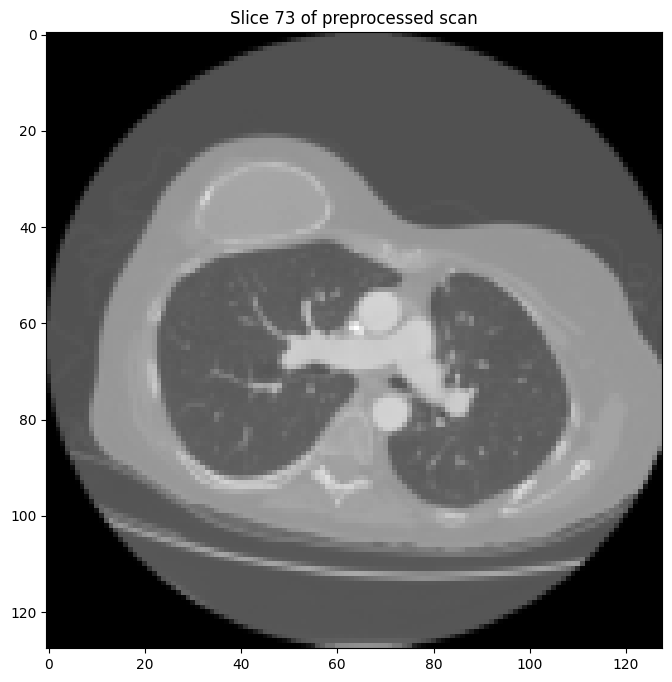

Min intensity: -2048.213281175333, Max intensity: 1643.204196836413


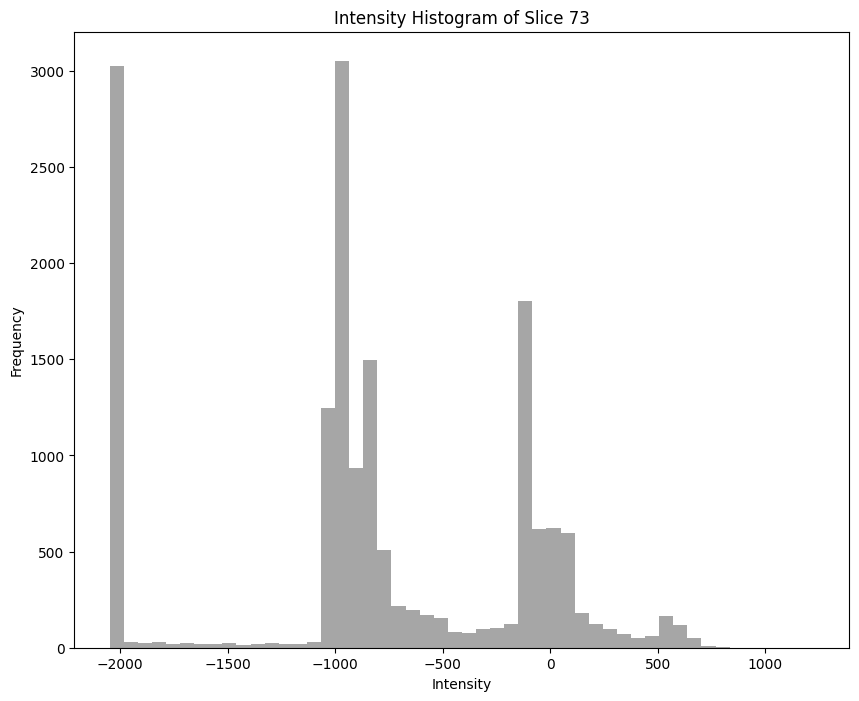

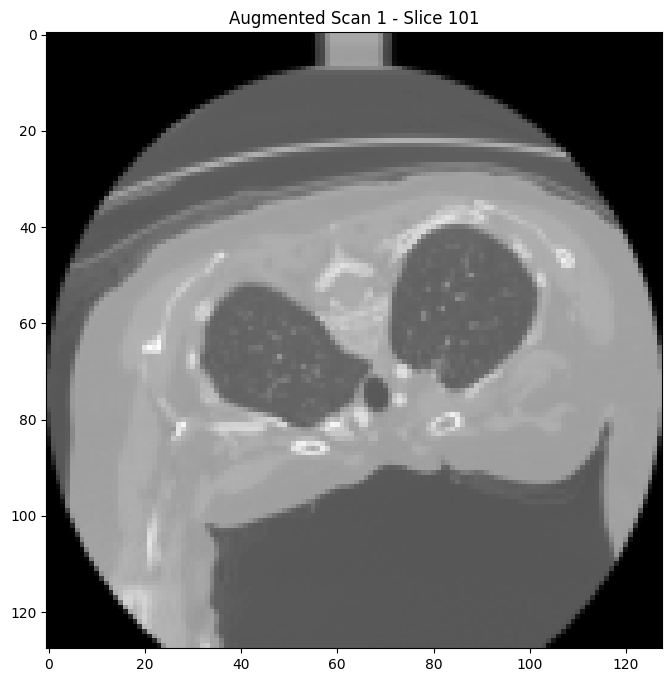

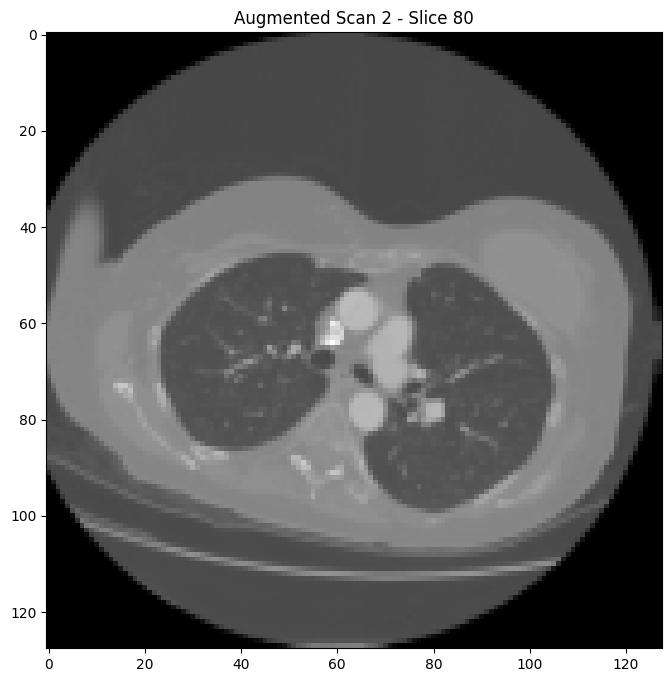

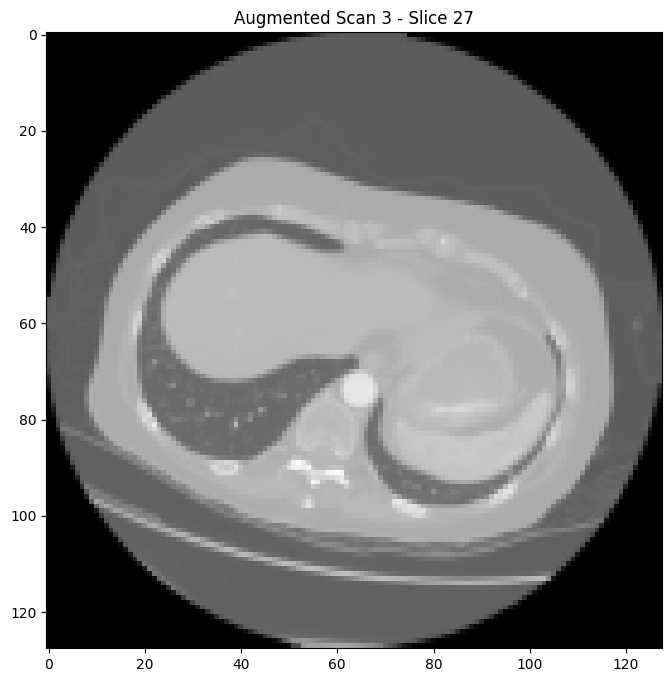

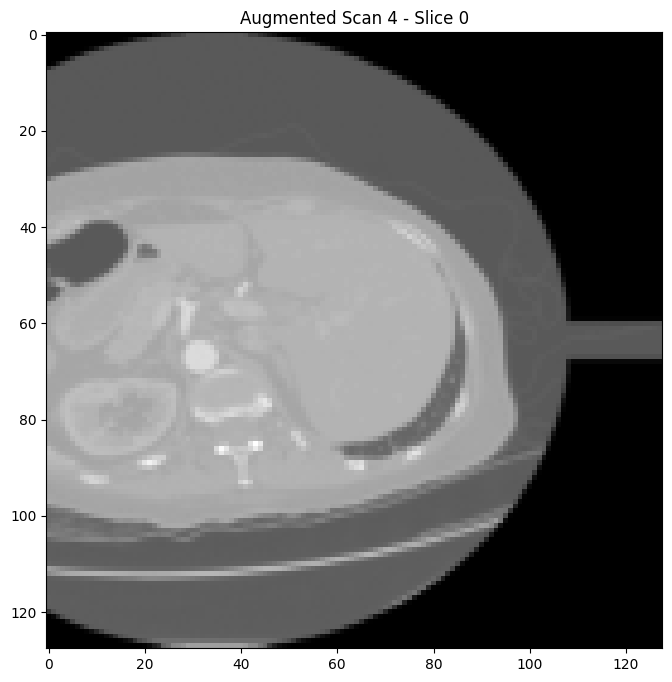

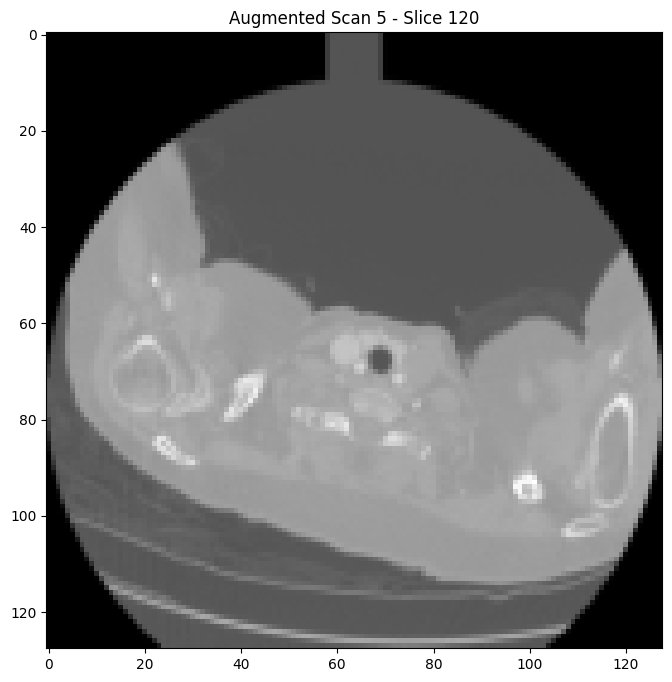

In [5]:
import os
import numpy as np
import SimpleITK as sitk
import scipy.ndimage as ndi
from skimage.transform import resize
import matplotlib.pyplot as plt

# Helper function to load .mhd and .raw files
def load_mhd_raw(file_path):
    img = sitk.ReadImage(file_path)
    img_array = sitk.GetArrayFromImage(img)
    return img_array, img

# Lung Segmentation
def apply_lung_mask(scan_file, mask_file):
    scan, _ = load_mhd_raw(scan_file)
    mask, _ = load_mhd_raw(mask_file)
    # Apply the mask to the scan (i.e., set all non-lung voxels to 0)
    segmented_lung = scan * mask
    return segmented_lung

# Intensity Normalization with check for constant scan
def normalize_intensity(scan):
    # Normalize voxel intensities to [0, 1]
    min_intensity = np.min(scan)
    max_intensity = np.max(scan)
    
    # Avoid division by zero if scan is constant
    if min_intensity == max_intensity:
        normalized_scan = np.zeros_like(scan)  # or np.ones_like(scan)
    else:
        normalized_scan = (scan - min_intensity) / (max_intensity - min_intensity)
    
    return normalized_scan

# Resampling (Isotropic Voxel Spacing) using SimpleITK
def resample_scan(scan, sitk_img, target_spacing=(1, 1, 1)):
    original_spacing = sitk_img.GetSpacing()
    original_size = sitk_img.GetSize()
    
    # Calculate new size based on target spacing
    new_size = [
        int(np.round(original_size[i] * (original_spacing[i] / target_spacing[i])))
        for i in range(3)
    ]
    
    resampled_img = sitk.Resample(
        sitk_img,
        new_size,
        sitk.Transform(),
        sitk.sitkLinear,
        sitk_img.GetOrigin(),
        target_spacing,
        sitk_img.GetDirection(),
        0,
        sitk_img.GetPixelID(),
    )
    
    resampled_scan = sitk.GetArrayFromImage(resampled_img)
    return resampled_scan

# Resize to final shape
def resize_scan(scan, target_shape=(128, 128, 128)):
    resized_scan = resize(scan, target_shape, mode='reflect', anti_aliasing=True)
    return resized_scan

# Custom 3D Data Augmentation
def augment_scan_3d(scan):
    # Random rotation along any axis
    axes = [(1, 2), (0, 2), (0, 1)]
    axis = axes[np.random.randint(0, len(axes))]  # Select a random axis pair
    angle = np.random.uniform(-30, 30)  # Rotation angle in degrees
    rotated_scan = ndi.rotate(scan, angle, axes=axis, reshape=False, mode='nearest')
    
    # Random flipping along any axis
    flip_axis = np.random.randint(0, 3)  # Choose an axis to flip
    flipped_scan = np.flip(rotated_scan, axis=flip_axis) if np.random.random() > 0.5 else rotated_scan
    
    # Add random Gaussian noise
    noise = np.random.normal(0, 0.01, flipped_scan.shape)
    noisy_scan = flipped_scan + noise
    
    return noisy_scan

# Main Preprocessing Function
def preprocess_scan(scan_file, mask_file, target_spacing=(1, 1, 1), augment=True, final_shape=(128, 128, 128)):
    # Apply lung mask
    lung_scan = apply_lung_mask(scan_file, mask_file)
    
    # Normalize intensity values
    normalized_scan = normalize_intensity(lung_scan)
    
    # Load the scan again as a SimpleITK image for resampling
    _, sitk_img = load_mhd_raw(scan_file)
    
    # Resample to isotropic voxel spacing
    resampled_scan = resample_scan(normalized_scan, sitk_img, target_spacing=target_spacing)
    
    # Apply custom 3D data augmentation
    if augment:
        augmented_scan = augment_scan_3d(resampled_scan)
    else:
        augmented_scan = resampled_scan
    
    # Resize to final shape
    resized_scan = resize_scan(augmented_scan, target_shape=final_shape)
    
    return resized_scan

# Example scan and mask file paths
scan_file = '/kaggle/input/luna16/subset0/subset0/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd'
mask_file = '/kaggle/input/luna16/seg-lungs-LUNA16/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.295298571102631191572192562523.mhd'

# Preprocess the scan: segmentation, resampling, and augmentation
preprocessed_scan = preprocess_scan(scan_file, mask_file)

# Check the shape of the preprocessed scan
print(f"Preprocessing completed. Preprocessed scan shape: {preprocessed_scan.shape}")

# Plot a random slice from the preprocessed scan
slice_idx = np.random.randint(0, preprocessed_scan.shape[0])
plt.imshow(preprocessed_scan[slice_idx], cmap='gray')
plt.title(f"Slice {slice_idx} of preprocessed scan")
plt.show()

# Verify the intensity normalization by checking the min and max values
print(f"Min intensity: {np.min(preprocessed_scan)}, Max intensity: {np.max(preprocessed_scan)}")

# Plot the histogram for the random slice to verify intensity range
plt.hist(preprocessed_scan[slice_idx].flatten(), bins=50, color='gray', alpha=0.7)
plt.title(f"Intensity Histogram of Slice {slice_idx}")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

# Verify randomization by running the preprocessing multiple times
for i in range(5):
    augmented_scan = preprocess_scan(scan_file, mask_file)
    slice_idx = np.random.randint(0, augmented_scan.shape[0])
    plt.imshow(augmented_scan[slice_idx], cmap='gray')
    plt.title(f"Augmented Scan {i+1} - Slice {slice_idx}")
    plt.show()


In [6]:
import pandas as pd

# Load the annotations file (CSV)
annotations_file = '/kaggle/input/luna16/candidates_V2/candidates_V2.csv'

# Read the CSV file into a pandas DataFrame
annotations_df = pd.read_csv(annotations_file)

# Display the first few rows of the annotations
print("First few rows of the annotations file:")
print(annotations_df.head())

# Get information about the structure of the annotations file
print("\nAnnotations file information:")
annotations_df.info()

# Check for null or missing values in the annotations
print("\nNull values in annotations file:")
print(annotations_df.isnull().sum())

# Check the column names (if needed)
print("\nColumn names in the annotations file:")
print(annotations_df.columns)

# Check for unique values in relevant columns like 'x', 'y', 'z' (coordinates)
# Assuming the first three columns represent the coordinates
print("\nUnique values in the first three columns (assuming x, y, z coordinates):")
print(annotations_df.iloc[:, :3].nunique())


First few rows of the annotations file:
                                           seriesuid     coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  68.420000  -74.480000   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -95.209361  -91.809406   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -24.766755 -120.379294   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -63.080000  -65.740000   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  52.946688  -92.688873   

       coordZ  class  
0 -288.700000      0  
1 -377.426350      0  
2 -273.361539      0  
3 -344.240000      0  
4 -241.067872      0  

Annotations file information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754975 entries, 0 to 754974
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   seriesuid  754975 non-null  object 
 1   coordX     754975 non-null  float64
 2   coordY     754975 non-null  float64
 

In [7]:
import pandas as pd

# Load the annotations file from the main directory
annotations_file = '/kaggle/input/luna16/annotations.csv'

# Load the CSV into a DataFrame
annotations_df = pd.read_csv(annotations_file)

# Display the first few rows of the annotations DataFrame
print(annotations_df.head())

# Display the structure and information about the annotations DataFrame
print(annotations_df.info())

# Display the column names
print("Column names in annotations file:", annotations_df.columns)

# Check for any missing values in the annotations DataFrame
print("Missing values in annotations file:")
print(annotations_df.isnull().sum())


                                           seriesuid      coordX      coordY  \
0  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222... -128.699421 -175.319272   
1  1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...  103.783651 -211.925149   
2  1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...   69.639017 -140.944586   
3  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...  -24.013824  192.102405   
4  1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...    2.441547  172.464881   

       coordZ  diameter_mm  
0 -298.387506     5.651471  
1 -227.121250     4.224708  
2  876.374496     5.786348  
3 -391.081276     8.143262  
4 -405.493732    18.545150  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1186 entries, 0 to 1185
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   seriesuid    1186 non-null   object 
 1   coordX       1186 non-null   float64
 2   coordY       1186 non-null   float64
 3   coordZ       1186 non-nu

Summary statistics for 'diameter_mm':
count    1186.000000
mean        8.306527
std         4.762033
min         3.253443
25%         5.107177
50%         6.433600
75%         9.696301
max        32.270030
Name: diameter_mm, dtype: float64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


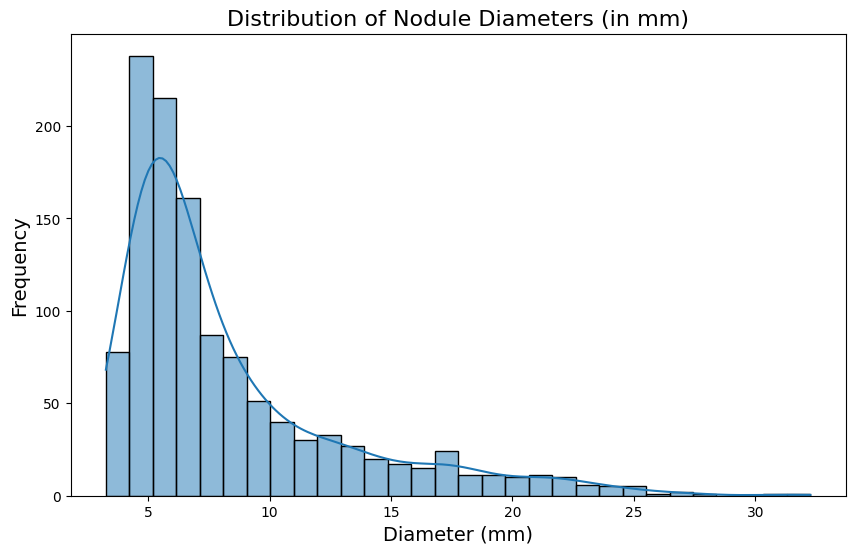

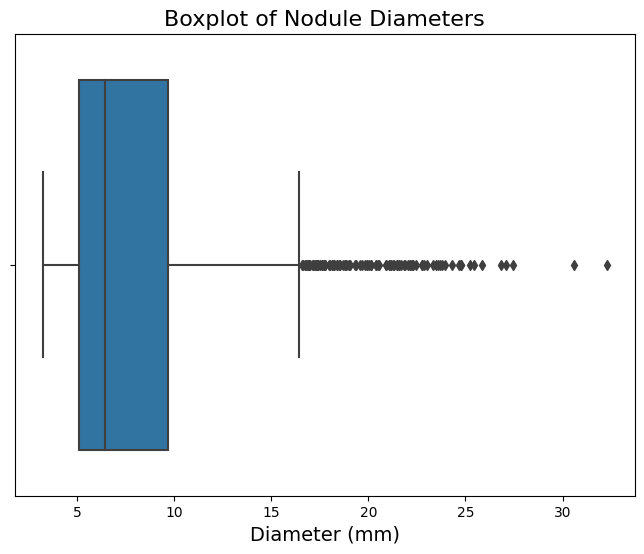

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the annotations file
annotations_file = '/kaggle/input/luna16/annotations.csv'
annotations = pd.read_csv(annotations_file)

# Analyze the 'diameter_mm' column
diameter_values = annotations['diameter_mm']

# Summary statistics
print("Summary statistics for 'diameter_mm':")
print(diameter_values.describe())

# Visualize the distribution
plt.figure(figsize=(10, 6))
sns.histplot(diameter_values, kde=True, bins=30)
plt.title('Distribution of Nodule Diameters (in mm)', fontsize=16)
plt.xlabel('Diameter (mm)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

# Optionally, plot a boxplot to check for outliers
plt.figure(figsize=(8, 6))
sns.boxplot(x=diameter_values)
plt.title('Boxplot of Nodule Diameters', fontsize=16)
plt.xlabel('Diameter (mm)', fontsize=14)
plt.show()


In [9]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import SimpleITK as sitk

# Function to load the entire CT scan (assuming .mhd format) and extract slices
def load_ct_scan(file_path):
    ct_scan = sitk.ReadImage(file_path)
    ct_array = sitk.GetArrayFromImage(ct_scan)  # Shape: [slices, height, width]
    return ct_array

# Function to extract a 3D patch around a given nodule using memory-mapped arrays
def extract_nodule_patch(ct_scan, nodule_location, patch_size=(64, 64, 64)):
    x, y, z = nodule_location
    x, y, z = int(x), int(y), int(z)  # Ensure coordinates are integers
    half_patch_size = tuple(int(s // 2) for s in patch_size)
    
    # Extract patch from the CT scan
    patch = ct_scan[
        x - half_patch_size[0]: x + half_patch_size[0],
        y - half_patch_size[1]: y + half_patch_size[1],
        z - half_patch_size[2]: z + half_patch_size[2]
    ]
    
    # Make sure the patch is of the desired size by padding if necessary
    patch = np.pad(patch, [(0, patch_size[0] - patch.shape[0]),
                           (0, patch_size[1] - patch.shape[1]),
                           (0, patch_size[2] - patch.shape[2])], mode='constant', constant_values=0)
    
    # Add an extra dimension to match the shape (64, 64, 64, 1)
    patch = np.expand_dims(patch, axis=-1)  # Shape: (64, 64, 64, 1)
    
    return patch

# Function to prepare features and labels
def prepare_features_and_labels(ct_scan_folder, annotations_file, patch_size=(64, 64, 64), batch_size=10):
    # Load the annotations.csv file
    annotations = pd.read_csv(annotations_file)
    
    # Define the files to store features and labels
    feature_file = "features.npy"
    label_file = "labels.csv"  # Saving labels as CSV
    
    # Create or open memory-mapped files to store features
    features_memmap = np.memmap(feature_file, dtype='float32', mode='w+', shape=(len(annotations), *patch_size, 1))
    
    # Prepare a list to hold labels for CSV
    labels_list = []
    
    # Process one patch at a time to minimize memory usage
    for i, (_, row) in enumerate(annotations.iterrows()):
        seriesuid = row['seriesuid']
        # Construct file path to the CT scan (adjust as per your dataset structure)
        file_path = f"{ct_scan_folder}/{seriesuid}.mhd"
        
        # Extract patch for each nodule
        nodule_location = (row['coordX'], row['coordY'], row['coordZ'])
        
        # Load the entire CT scan to extract the patch
        ct_scan = load_ct_scan(file_path)
        
        # Extract the patch for the nodule location
        patch = extract_nodule_patch(ct_scan, nodule_location, patch_size)
        
        # Label the patch based on the diameter_mm column
        threshold = 6.43  # Example threshold for diameter, adjust as needed
        label = 1 if row['diameter_mm'] > threshold else 0

        labels_list.append(label)  # Append the label to the list

        # Store the patch in the memory-mapped array
        features_memmap[i] = patch

        # Save every batch_size patches to disk
        if (i + 1) % batch_size == 0 or i == len(annotations) - 1:
            print(f"Processed batch {i // batch_size + 1}, saving...")
    
    # After the loop, save the labels to CSV
    labels_df = pd.DataFrame({'labels': labels_list})
    labels_df.to_csv(label_file, index=False)
    
    # Verify the number of labels written and check the first few labels
    print(f"Finished writing patches. Number of labels: {len(labels_list)}")
    print(f"First 10 labels: {labels_list[:10]}")
    
    return "Processing complete, intermediate results saved."

# Example usage
ct_scan_folder = '/kaggle/input/luna16/seg-lungs-LUNA16/seg-lungs-LUNA16/'
annotations_file = '/kaggle/input/luna16/annotations.csv'

# Prepare features and labels, process one patch at a time
message = prepare_features_and_labels(ct_scan_folder, annotations_file, patch_size=(64, 64, 64), batch_size=10)

print(message)


Processed batch 1, saving...
Processed batch 2, saving...
Processed batch 3, saving...
Processed batch 4, saving...
Processed batch 5, saving...
Processed batch 6, saving...
Processed batch 7, saving...
Processed batch 8, saving...
Processed batch 9, saving...
Processed batch 10, saving...
Processed batch 11, saving...
Processed batch 12, saving...
Processed batch 13, saving...
Processed batch 14, saving...
Processed batch 15, saving...
Processed batch 16, saving...
Processed batch 17, saving...
Processed batch 18, saving...
Processed batch 19, saving...
Processed batch 20, saving...
Processed batch 21, saving...
Processed batch 22, saving...
Processed batch 23, saving...
Processed batch 24, saving...
Processed batch 25, saving...
Processed batch 26, saving...
Processed batch 27, saving...
Processed batch 28, saving...
Processed batch 29, saving...
Processed batch 30, saving...
Processed batch 31, saving...
Processed batch 32, saving...
Processed batch 33, saving...
Processed batch 34,

In [10]:
import os

# Define the path to the working directory
working_directory = '/kaggle/working/'

# List all files in the directory
saved_files = os.listdir(working_directory)

# Display the names of the files in the directory
print("Files in '/kaggle/working/':")
for file in saved_files:
    print(file)

# If you're looking for specific files (e.g., batch data files saved as .npy or .csv)
batch_files = [file for file in saved_files if file.endswith('.npy') or file.endswith('.csv')]

# Output the list of batch files
print("Batch files found:")
for file in batch_files:
    print(file)


Files in '/kaggle/working/':
features.npy
.virtual_documents
labels.csv
Batch files found:
features.npy
labels.csv


In [11]:
import pandas as pd
import numpy as np

# Load the annotations.csv file to get the labels
annotations_file = '/kaggle/input/luna16/annotations.csv'
annotations = pd.read_csv(annotations_file)

# Now load the memory-mapped arrays for features
features_memmap = np.memmap(
    '/kaggle/working/features.npy', dtype='float32', mode='r', shape=(len(annotations), 64, 64, 64, 1)
)

# Create labels based on the 'diameter_mm' column in the annotations
labels_memmap = np.zeros(len(annotations), dtype='int32')

# Assuming that diameter_mm > 0 means the nodule is present (label = 1)
# and diameter_mm == 0 means no nodule (label = 0)
labels_memmap = annotations['diameter_mm'].apply(lambda x: 1 if x > 0 else 0).values

# Check the shapes of the features and labels
print(f"Features shape: {features_memmap.shape}")
print(f"Labels shape: {labels_memmap.shape}")

# Optionally, check the first few examples
print(f"First feature shape: {features_memmap[0].shape}")
print(f"First label: {labels_memmap[0]}")


Features shape: (1186, 64, 64, 64, 1)
Labels shape: (1186,)
First feature shape: (64, 64, 64, 1)
First label: 1


In [12]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np
import joblib
import pandas as pd

# Parameters
n_components = 16  # Number of visual words (clusters)
batch_size = 20  # Ensure batch_size >= n_clusters
kmeans_batch_size = 100  # MiniBatchKMeans mini-batch size

# Load metadata
annotations_file = '/kaggle/input/luna16/annotations.csv'
annotations = pd.read_csv(annotations_file)
num_samples = len(annotations)

# Memory-mapped features
features_memmap = np.memmap(
    '/kaggle/working/features.npy', dtype='float32', mode='r', shape=(num_samples, 64, 64, 64, 1)
)

# Initialize MiniBatchKMeans
print("Initializing MiniBatchKMeans...")
kmeans = MiniBatchKMeans(n_clusters=n_components, batch_size=kmeans_batch_size, random_state=42, n_init="auto")

# Train MiniBatchKMeans in batches
print("Training MiniBatchKMeans in batches...")
for start_idx in range(0, num_samples, batch_size):
    end_idx = min(start_idx + batch_size, num_samples)
    batch_features = features_memmap[start_idx:end_idx]  # Load batch
    
    if batch_features.shape[0] < n_components:
        print(f"Skipping final batch with size {batch_features.shape[0]} < n_clusters")
        continue
    
    batch_flattened = batch_features.reshape(batch_features.shape[0], -1)  # Flatten
    kmeans.partial_fit(batch_flattened)  # Incremental training
    print(f"Processed batch {start_idx // batch_size + 1}/{(num_samples + batch_size - 1) // batch_size}")

# Assign visual words for the entire dataset in batches
print("Assigning visual words in batches...")
visual_words = np.zeros(num_samples, dtype=np.int32)
for start_idx in range(0, num_samples, batch_size):
    end_idx = min(start_idx + batch_size, num_samples)
    batch_features = features_memmap[start_idx:end_idx]  # Load batch
    batch_flattened = batch_features.reshape(batch_features.shape[0], -1)  # Flatten
    
    visual_words[start_idx:end_idx] = kmeans.predict(batch_flattened)  # Predict visual words
    print(f"Assigned visual words for batch {start_idx // batch_size + 1}/{(num_samples + batch_size - 1) // batch_size}")

# Generate histograms with normalization
print("Generating histograms with normalization...")
histograms = np.zeros((num_samples, n_components), dtype=np.int32)
for i, vw in enumerate(visual_words):
    histograms[i, vw] += 1

# Normalize histograms to get relative frequencies
histograms = histograms / histograms.sum(axis=1, keepdims=True)

# Save results
print("Saving results...")
joblib.dump(kmeans, '/kaggle/working/kmeans_model.joblib')
np.save('/kaggle/working/visual_word_histograms.npy', histograms)
np.save('/kaggle/working/visual_words.npy', visual_words)

print("Visual Word Modeling completed.")


Initializing MiniBatchKMeans...
Training MiniBatchKMeans in batches...
Processed batch 1/60
Processed batch 2/60
Processed batch 3/60
Processed batch 4/60
Processed batch 5/60
Processed batch 6/60
Processed batch 7/60
Processed batch 8/60
Processed batch 9/60
Processed batch 10/60
Processed batch 11/60
Processed batch 12/60
Processed batch 13/60
Processed batch 14/60
Processed batch 15/60
Processed batch 16/60
Processed batch 17/60
Processed batch 18/60
Processed batch 19/60
Processed batch 20/60
Processed batch 21/60
Processed batch 22/60
Processed batch 23/60
Processed batch 24/60
Processed batch 25/60
Processed batch 26/60
Processed batch 27/60
Processed batch 28/60
Processed batch 29/60
Processed batch 30/60
Processed batch 31/60
Processed batch 32/60
Processed batch 33/60
Processed batch 34/60
Processed batch 35/60
Processed batch 36/60
Processed batch 37/60
Processed batch 38/60
Processed batch 39/60
Processed batch 40/60
Processed batch 41/60
Processed batch 42/60
Processed batc

In [13]:
import numpy as np

histograms = np.load('/kaggle/working/visual_word_histograms.npy')
visual_words = np.load('/kaggle/working/visual_words.npy')

print(f"Histograms shape: {histograms.shape}")
print(f"Visual words shape: {visual_words.shape}")
print(f"First histogram: {histograms[0]}")
print(f"First visual word: {visual_words[0]}")


Histograms shape: (1186, 16)
Visual words shape: (1186,)
First histogram: [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
First visual word: 4


In [14]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Flatten, Dense, GlobalAveragePooling3D
from tensorflow.keras.models import Model
from tqdm import tqdm

# Parameters
input_shape = (64, 64, 64, 1)  # 3D input shape
batch_size = 16
features_file = '/kaggle/working/features.npy'

# Load 3D patches
print("Loading 3D patches...")
patches = np.memmap(features_file, dtype='float32', mode='r', shape=(1186, *input_shape))

# Define a simple 3D CNN model
def build_3d_cnn_feature_extractor(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv3D(32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = MaxPooling3D(pool_size=2)(x)
    x = Conv3D(64, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling3D(pool_size=2)(x)
    x = Conv3D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = GlobalAveragePooling3D()(x)  # Reduce dimensions to a feature vector
    outputs = x  # Output feature embeddings
    model = Model(inputs, outputs)
    return model

# Initialize the model
print("Initializing the 3D CNN model...")
model = build_3d_cnn_feature_extractor(input_shape)
print("Model summary:")
model.summary()

# Extract features in batches
print("Extracting features...")
deep_features = []
for start_idx in tqdm(range(0, patches.shape[0], batch_size)):
    end_idx = min(start_idx + batch_size, patches.shape[0])
    batch_patches = patches[start_idx:end_idx]
    batch_features = model.predict(batch_patches, verbose=0)
    deep_features.append(batch_features)

# Combine the features
deep_features = np.concatenate(deep_features, axis=0)
print(f"Deep features shape: {deep_features.shape}")

# Save the extracted features
np.save('/kaggle/working/deep_features.npy', deep_features)
print("Deep features saved to '/kaggle/working/deep_features.npy'.")


Loading 3D patches...
Initializing the 3D CNN model...
Model summary:


2025-07-24 06:24:56.703235: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 64, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 64, 64, 64, 32) │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 32, 32, 32, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 32, 32, 32, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 16, 16, 16, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 16, 16, 16,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling3d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling3D)        │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,568 (1.06 MB)

 Trainable params: 277,568 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

Extracting features...


100%|██████████| 75/75 [03:10<00:00,  2.54s/it]

Deep features shape: (1186, 128)
Deep features saved to '/kaggle/working/deep_features.npy'.


In [15]:
import pandas as pd
import numpy as np

# Load the labels from the CSV file
labels_file = '/kaggle/working/labels.csv'
labels_df = pd.read_csv(labels_file)

# Check the first few rows of the labels DataFrame
print("First few rows of labels:")
print(labels_df.head())

# Check the shape of the labels to ensure it's consistent with the number of features
print(f"Labels shape: {labels_df.shape}")

# Convert labels to a numpy array if necessary
# Convert labels to a numpy array (flatten the DataFrame and extract the values)
labels = labels_df['labels'].values

# Ensure the labels are now in the correct 1D format
print(f"Labels shape after conversion: {labels.shape}")


# Optionally, verify if the length matches the number of deep features
print(f"Deep features shape: {deep_features.shape}")
print(f"Labels length: {len(labels)}")


First few rows of labels:
   labels
0       0
1       0
2       0
3       1
4       1
Labels shape: (1186, 1)
Labels shape after conversion: (1186,)
Deep features shape: (1186, 128)
Labels length: 1186


In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load Labels and Features
labels_df = pd.read_csv('/kaggle/working/labels.csv')
labels = labels_df['labels'].values
deep_features = np.load('/kaggle/working/deep_features.npy')

# SMOTE for Balancing Dataset
smote = SMOTE(random_state=42)
deep_features_resampled, labels_resampled = smote.fit_resample(deep_features, labels)

print(f"Resampled features shape: {deep_features_resampled.shape}")
print(f"Resampled labels shape: {labels_resampled.shape}")

# Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_resampled), y=labels_resampled)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# --- SVM Model ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_roc_auc_scores, svm_f1_scores = [], []

for train_idx, test_idx in skf.split(deep_features_resampled, labels_resampled):
    X_train, X_test = deep_features_resampled[train_idx], deep_features_resampled[test_idx]
    y_train, y_test = labels_resampled[train_idx], labels_resampled[test_idx]
    
    # SVM Classifier
    svm_clf = SVC(probability=True, kernel='rbf', random_state=42, class_weight='balanced')
    svm_clf.fit(X_train, y_train)
    
    svm_predictions = svm_clf.predict(X_test)
    svm_probabilities = svm_clf.predict_proba(X_test)[:, 1]
    
    # Metrics
    svm_roc_auc = roc_auc_score(y_test, svm_probabilities)
    svm_f1 = classification_report(y_test, svm_predictions, output_dict=True, zero_division=0)['macro avg']['f1-score']
    svm_roc_auc_scores.append(svm_roc_auc)
    svm_f1_scores.append(svm_f1)

print(f"SVM Average ROC-AUC Score: {np.mean(svm_roc_auc_scores):.4f}")
print(f"SVM Average F1-Score: {np.mean(svm_f1_scores):.4f}")

# --- Neural Network Model ---
nn_roc_auc_scores, nn_f1_scores = [], []

for train_idx, test_idx in skf.split(deep_features_resampled, labels_resampled):
    X_train, X_test = deep_features_resampled[train_idx], deep_features_resampled[test_idx]
    y_train, y_test = labels_resampled[train_idx], labels_resampled[test_idx]
    
    # Neural Network
    nn_model = Sequential([
        Input(shape=(deep_features_resampled.shape[1],)),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    nn_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    nn_model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), 
                 class_weight=class_weight_dict, verbose=0)
    
    # Predictions
    nn_predictions_prob = nn_model.predict(X_test).ravel()
    nn_predictions = (nn_predictions_prob > 0.5).astype(int)
    
    # Metrics
    precision, recall, _ = precision_recall_curve(y_test, nn_predictions_prob)
    nn_roc_auc = auc(recall, precision)
    nn_f1 = classification_report(y_test, nn_predictions, output_dict=True, zero_division=0)['macro avg']['f1-score']
    nn_roc_auc_scores.append(nn_roc_auc)
    nn_f1_scores.append(nn_f1)

print(f"Neural Network Average ROC-AUC Score: {np.mean(nn_roc_auc_scores):.4f}")
print(f"Neural Network Average F1-Score: {np.mean(nn_f1_scores):.4f}")


ModuleNotFoundError: No module named 'sklearn.utils._metadata_requests'

In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import IsolationForest
from sklearn.metrics import roc_auc_score, f1_score, recall_score

# --- PCA + SVM ---
# Apply PCA for dimensionality reduction
pca = PCA(n_components=50)  # Adjust number of components as needed
X_pca = pca.fit_transform(deep_features_resampled)

# Train-test split for PCA + SVM
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_roc_auc_scores_pca, svm_f1_scores_pca = [], []

for train_idx, test_idx in skf.split(X_pca, labels_resampled):
    X_train, X_test = X_pca[train_idx], X_pca[test_idx]
    y_train, y_test = labels_resampled[train_idx], labels_resampled[test_idx]

    # SVM Classifier
    svm_clf_pca = SVC(probability=True, kernel='rbf', random_state=42, class_weight='balanced')
    svm_clf_pca.fit(X_train, y_train)

    # Predictions
    svm_predictions_pca = svm_clf_pca.predict(X_test)
    svm_probabilities_pca = svm_clf_pca.predict_proba(X_test)[:, 1]

    # Metrics
    svm_roc_auc_pca = roc_auc_score(y_test, svm_probabilities_pca)
    svm_f1_pca = f1_score(y_test, svm_predictions_pca, zero_division=0)
    svm_roc_auc_scores_pca.append(svm_roc_auc_pca)
    svm_f1_scores_pca.append(svm_f1_pca)

print(f"PCA + SVM Average ROC-AUC Score: {np.mean(svm_roc_auc_scores_pca):.4f}")
print(f"PCA + SVM Average F1-Score: {np.mean(svm_f1_scores_pca):.4f}")

# --- Isolation Forest ---
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(deep_features_resampled)

# Predict anomalies
iso_scores = iso_forest.decision_function(deep_features_resampled)  # Anomaly scores
iso_pred = iso_forest.predict(deep_features_resampled)
iso_pred = [1 if x == -1 else 0 for x in iso_pred]  # Convert -1 to 1 (anomaly), 1 to 0 (normal)

# Evaluate Isolation Forest
iso_f1 = f1_score(labels_resampled, iso_pred, zero_division=0)
iso_recall = recall_score(labels_resampled, iso_pred, zero_division=0)
iso_auc = roc_auc_score(labels_resampled, iso_scores)  # Use anomaly scores for AUC
print(f"Isolation Forest F1 Score: {iso_f1:.4f}")
print(f"Isolation Forest Recall: {iso_recall:.4f}")
print(f"Isolation Forest ROC-AUC: {iso_auc:.4f}")


In [ ]:
import pandas as pd

# Baseline Results (from your previous code)
baseline_results = {
    "Method": ["Baseline SVM", "Baseline Neural Network"],
    "ROC-AUC": [np.mean(svm_roc_auc_scores), np.mean(nn_roc_auc_scores)],
    "F1-Score": [np.mean(svm_f1_scores), np.mean(nn_f1_scores)],
    "Recall": ["-", "-"],  # Recall not explicitly calculated for baseline
    "Accuracy": ["-", "-"],  # Accuracy can be added if calculated
}

# PCA + SVM Results
pca_svm_results = {
    "Method": "PCA + SVM",
    "ROC-AUC": np.mean(svm_roc_auc_scores_pca),
    "F1-Score": np.mean(svm_f1_scores_pca),
    "Recall": "-",  # Optional for PCA + SVM
    "Accuracy": "-",  # Optional for PCA + SVM
}

# Isolation Forest Results
iso_results = {
    "Method": "Isolation Forest",
    "ROC-AUC": iso_auc,
    "F1-Score": iso_f1,
    "Recall": iso_recall,
    "Accuracy": "-",  # Optional for Isolation Forest
}

# Combine Results
results_df = pd.DataFrame(baseline_results)
results_df = pd.concat([results_df, pd.DataFrame([pca_svm_results, iso_results])], ignore_index=True)

# Print Comparison Table
print("\nComparison of Anomaly Detection Methods:")
print(results_df.to_string(index=False))


In [ ]:
X_test = np.expand_dims(X_test, axis=-1)  # Add channel dimension if needed
print(f"X_test shape after reshaping: {X_test.shape}")


In [ ]:
import matplotlib.pyplot as plt
import SimpleITK as sitk

# Load a CT scan slice (example)
image_path = '/kaggle/input/luna16/seg-lungs-LUNA16/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.100620385482151095585000946543.mhd'
image = sitk.ReadImage(image_path)
image_array = sitk.GetArrayFromImage(image)

# Plot the slice (e.g., middle slice)
slice_idx = image_array.shape[0] // 2
plt.imshow(image_array[slice_idx], cmap='gray')
plt.title('CT Slice - Detected Nodules')
plt.colorbar()
plt.show()

# Add annotations and detected nodules
# Example: Overlay the nodule annotations (coordinates from your model)
# Use scatter plot or bounding boxes for the detected nodules


In [ ]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

# Load the .mhd file (header + raw data)
file_path = '/kaggle/input/luna16/seg-lungs-LUNA16/seg-lungs-LUNA16/1.3.6.1.4.1.14519.5.2.1.6279.6001.100620385482151095585000946543.mhd'
image = sitk.ReadImage(file_path)

# Convert the image to a numpy array
image_array = sitk.GetArrayFromImage(image)

# Assuming you have a pre-generated anomaly mask with the same shape as the image array
# Example: Create a dummy anomaly mask (this should be replaced with your actual mask)
# 1 indicates anomaly, 0 indicates normal
anomaly_mask = np.zeros_like(image_array)
anomaly_mask[30:60, 50:80, 50:80] = 1  # Example: Marking a region as an anomaly (change this)

# Display a slice of the image with anomaly highlighted (e.g., the middle slice along the z-axis)
slice_index = image_array.shape[0] // 2  # Middle slice

# Create the plot
plt.figure(figsize=(10, 8))
plt.imshow(image_array[slice_index], cmap='gray')  # Original CT scan slice
plt.imshow(anomaly_mask[slice_index], cmap='jet', alpha=0.5)  # Overlay the anomaly mask with transparency
plt.title(f'Slice {slice_index} with Anomaly Highlighted')
plt.colorbar()
plt.show()


In [ ]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Apply PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(deep_features)

# Train SVM on PCA-reduced features
svm_clf_pca = SVC(probability=True, kernel='rbf', random_state=42, class_weight='balanced')
svm_clf_pca.fit(X_pca, labels)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay, auc
import numpy as np
import os

# Create output directories for images
output_dir = '/kaggle/working/plots'
os.makedirs(output_dir, exist_ok=True)

# --- 1. ROC Curves ---
def plot_roc_curve(y_true, y_scores, title, filename):
    """Custom function to plot the ROC curve and save the image."""
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{title} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve: " + title)
    plt.legend(loc="best")
    plt.savefig(os.path.join(output_dir, filename))  # Save the plot
    plt.show()

# Plotting and saving ROC curves
plot_roc_curve(labels_resampled, svm_clf.predict_proba(deep_features_resampled)[:, 1], "Baseline SVM", "roc_baseline_svm.png")
nn_probabilities = nn_model.predict(deep_features_resampled).ravel()
plot_roc_curve(labels_resampled, nn_probabilities, "Baseline Neural Network", "roc_nn.png")
labels_trimmed = labels[:1186]
plot_roc_curve(labels_trimmed, svm_clf_pca.predict_proba(X_pca)[:, 1], "PCA + SVM", "roc_pca_svm.png")
iso_scores = iso_forest.decision_function(deep_features_resampled)
plot_roc_curve(labels_resampled, iso_scores, "Isolation Forest", "roc_isolation_forest.png")

# --- 2. Confusion Matrices ---
def plot_confusion_matrix(y_true, y_pred, title, filename):
    """Plot and save confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(title)
    plt.savefig(os.path.join(output_dir, filename))  # Save the plot
    plt.show()

# Plotting and saving confusion matrices
plot_confusion_matrix(labels_resampled, svm_clf.predict(deep_features_resampled), "Confusion Matrix: Baseline SVM", "cm_baseline_svm.png")
plot_confusion_matrix(labels_resampled, (nn_model.predict(deep_features_resampled).ravel() > 0.5).astype(int), "Confusion Matrix: Baseline Neural Network", "cm_nn.png")
plot_confusion_matrix(labels_trimmed, svm_clf_pca.predict(X_pca), "Confusion Matrix: PCA + SVM", "cm_pca_svm.png")
plot_confusion_matrix(labels_resampled, iso_pred, "Confusion Matrix: Isolation Forest", "cm_isolation_forest.png")

# --- 3. Anomaly Detection Heatmaps ---
def plot_anomaly_heatmap(features, predictions, title, filename):
    """Plot and save anomaly heatmap."""
    plt.figure(figsize=(10, 6))
    sns.heatmap(np.array(predictions).reshape(-1, 1).T, cmap='coolwarm', cbar=True)
    plt.title(title)
    plt.xlabel('Samples')
    plt.ylabel('Anomaly Prediction')
    plt.savefig(os.path.join(output_dir, filename))  # Save the plot
    plt.show()

# Plotting and saving heatmaps
plot_anomaly_heatmap(deep_features_resampled, svm_clf.predict(deep_features_resampled), "Anomaly Heatmap: Baseline SVM", "heatmap_baseline_svm.png")
plot_anomaly_heatmap(deep_features_resampled, (nn_model.predict(deep_features_resampled).ravel() > 0.5).astype(int), "Anomaly Heatmap: Baseline Neural Network", "heatmap_nn.png")
plot_anomaly_heatmap(X_pca, svm_clf_pca.predict(X_pca), "Anomaly Heatmap: PCA + SVM", "heatmap_pca_svm.png")
plot_anomaly_heatmap(deep_features_resampled, iso_pred, "Anomaly Heatmap: Isolation Forest", "heatmap_isolation_forest.png")

In [ ]:
print(f"Labels shape: {labels_resampled.shape}")
print(f"Deep features shape: {deep_features_resampled.shape}")
print(f"X_pca shape: {X_pca.shape}")
print(f"Predictions shape for SVM: {svm_clf.predict(deep_features_resampled).shape}")


In [ ]:
# Assuming you have a variable `deep_features_resampled` which contains your extracted features
features = deep_features_resampled  # Replace with your actual feature data

# Save the preprocessed data
with open('/kaggle/working/preprocessed_data.pkl', 'wb') as f:
    pickle.dump(features, f)

print("Preprocessed data saved successfully!")


In [ ]:
# Save trained model weights
model.save('/kaggle/working/cnn_model.h5')


In [ ]:
# Example: Save evaluation metrics results
evaluation_results = {
    'accuracy': accuracy,
    'recall': recall,
    'f1_score': f1,
    'roc_auc': auc
}

with open('/kaggle/working/evaluation_results.pkl', 'wb') as f:
    pickle.dump(evaluation_results, f)


In [ ]:
import nbformat
import base64
import os

def save_images_from_notebook(notebook_path, output_folder):
    # Load the notebook
    with open(notebook_path, 'r', encoding='utf-8') as nb_file:
        notebook = nbformat.read(nb_file, as_version=4)

    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    image_count = 0

    # Iterate through cells in the notebook
    for cell in notebook.cells:
        if 'outputs' in cell:
            for output in cell['outputs']:
                if output['output_type'] == 'display_data' and 'image/png' in output['data']:
                    # Decode base64 image
                    image_data = base64.b64decode(output['data']['image/png'])
                    
                    # Save the image
                    image_path = os.path.join(output_folder, f"image_{image_count}.png")
                    with open(image_path, 'wb') as img_file:
                        img_file.write(image_data)
                    image_count += 1

    print(f"Saved {image_count} images to '{output_folder}'.")

# Usage example
notebook_path = 'path_to_your_notebook.ipynb'  # Replace with the path to your notebook
output_folder = 'output_images'  # Replace with your desired output folder
save_images_from_notebook(notebook_path, output_folder)
